In [1]:
import pandas as pd
import numpy as np 
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline

### Loading the data 

In [2]:
data = pd.read_csv('Data/data.csv')
pd.set_option('display.max_columns', None)
data.shape

(119011, 34)

In [3]:
data.tail()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,PLAYER_NAME,PLAYER_ID,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,PLAYER_AST,PLAYER_WEIGHT,DEFENDER_OREB,DEFENDER_DREB,DEFENDER_STL,DEFENDER_BLK,DEFENDER_WEIGHT
119006,21400175,"NOV 21, 2014 - MIL @ TOR",A,L,-42,3,4,8:55,15.2,0,0.8,22.9,3,missed,BRUNO CABOCLO,203998,10.6,0,0,JARED DUDLEY,201162,197.5,202.5,7.2,46.8,38.5,71.6,1.8,101.25,0.1,0.1,0.0,0.1,98.10
119007,21400003,"OCT 28, 2014 - HOU @ LAL",A,W,18,3,3,1:35,3.3,1,2.4,6.7,2,made,JULIUS RANDLE,203944,5.3,1,2,KOSTAS PAPANIKOLAOU,203123,200.0,202.5,4.2,35.0,29.2,72.2,2.0,101.25,0.0,0.0,0.0,0.0,112.50
119008,21400003,"OCT 28, 2014 - HOU @ LAL",A,W,18,2,2,10:10,24.0,0,0.3,4.1,2,made,JULIUS RANDLE,203944,3.2,1,2,DWIGHT HOWARD,2730,207.5,202.5,15.8,59.3,50.0,52.8,1.2,119.25,0.0,0.0,0.0,0.0,112.50
119009,21400744,"FEB 05, 2015 - SAC vs. DAL",H,L,-23,9,4,3:21,13.3,5,5.4,21.9,2,missed,RICKY LEDO,203495,5.0,0,0,NIK STAUSKAS,203917,195.0,201.0,4.4,36.5,32.2,85.9,0.9,92.25,0.9,1.2,0.4,0.1,88.00
119010,21400498,"JAN 03, 2015 - MIN vs. UTA",H,L,-12,7,4,0:26,2.6,1,0.7,4.3,2,made,TOURE' MURRY,203315,2.8,1,2,ANTHONY BENNETT,203461,200.0,192.5,5.2,42.1,30.4,64.1,0.8,110.25,0.2,0.0,0.2,0.0,87.75


In [4]:
data.columns.values

array(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'PLAYER_NAME', 'PLAYER_ID', 'PLAYER_HEIGHT',
       'DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
       'PLAYER_FT%', 'PLAYER_AST', 'PLAYER_WEIGHT', 'DEFENDER_OREB',
       'DEFENDER_DREB', 'DEFENDER_STL', 'DEFENDER_BLK', 'DEFENDER_WEIGHT'],
      dtype=object)

### Manipulating the data

In [5]:
# separate data into matrix of predictor variables and vector of target variables
names = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
         'DRIBBLES', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
         'PLAYER_HEIGHT','DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
          'PLAYER_FT%','DEFENDER_STL', 'DEFENDER_BLK', 'SHOT_RESULT']

# converting data to usable numerical data
# todo: move this to preprocessing 
def convert_time(time_string):
    time = time_string.split(':')
    return float(time[0])*60 + float(time[1])

# convert game_clock to seconds
data['GAME_CLOCK'] = data['GAME_CLOCK'].apply(lambda x: convert_time(x))

# convert shot_result to either 0 or 1
data['SHOT_RESULT'] = (data['SHOT_RESULT'] == 'made').astype(int)
# convert win to either 0 

# encode categorical data 
data_encoded = pd.get_dummies(data[names])

# split into train and test set with roughly 75-25 split
train, test = train_test_split(data_encoded, test_size=0.25)
Xtrain = train.drop(['SHOT_RESULT'], axis=1)
ytrain = train['SHOT_RESULT']
Xtest = test.drop(['SHOT_RESULT'], axis=1)
ytest = test['SHOT_RESULT']

### Setting the baseline

First baseline we consider is to predict every shot within 5 feet of the basket as a make and anything else as a miss. 

In [6]:
yhat = (Xtest['SHOT_DIST'] <= 5).astype(int)
acc = np.mean(yhat == ytest)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.613552


A more complex baseline we can try is to use k-nn algorithm. First, we need to normalize the data so that no one parameter exerts more influence on the result than others. 

In [7]:
# without normalizing data 
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [8]:
yhat_ts = neigh.predict(Xtest)
acc = np.mean(ytest.values == yhat_ts)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.631903


In [9]:
# with normaliziation 
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_norm = scaler.transform(Xtrain)
scaler.fit(Xtest)
Xtest_norm = scaler.transform(Xtest)

neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain_norm,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [10]:
yhat_ts_norm = neigh.predict(Xtest_norm)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.999933


In [11]:
# finding out why the accuracy is so high 
Xtrain[Xtrain['FGM'] >= 1]

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,FGM,PTS,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H
5515,12,3,168.0,6.3,6,18.5,2,0.5,1,2,187.5,190.0,21.7,46.8,41.5,86.3,0.7,0.2,0,1
70528,8,4,494.0,17.9,0,1.1,2,2.0,1,2,202.5,210.0,10.3,50.2,0.0,71.7,0.5,0.4,1,0
52950,11,4,247.0,15.5,1,17.7,2,3.0,1,2,187.5,187.5,18.9,44.5,28.5,75.2,1.2,0.0,0,1
8534,9,3,454.0,14.8,2,6.8,2,5.5,1,2,200.0,207.5,13.4,46.7,40.7,85.9,0.9,1.9,0,1
91201,5,3,626.0,19.1,6,6.4,2,2.3,1,2,202.5,192.5,13.3,43.9,28.3,74.4,1.1,0.2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59156,28,7,187.0,3.7,10,22.9,2,5.5,1,2,187.5,195.0,21.0,43.4,34.3,86.4,1.2,1.1,1,0
22228,21,4,179.0,23.0,0,4.0,2,2.4,1,2,207.5,195.0,24.1,46.7,25.0,78.2,0.3,0.2,0,1
63228,5,2,341.0,12.6,1,15.8,2,5.6,1,2,193.0,192.5,21.5,47.0,28.4,76.8,1.9,0.7,1,0
9874,3,1,241.0,16.7,7,17.3,2,3.3,1,2,192.5,197.5,12.1,43.7,33.1,84.8,0.8,0.2,0,1


In [12]:
# FGM is not the total field goals made, but whether or not that 
# individual shot was made or not, so we need to drop this 
Xtrain_new = Xtrain.drop(['FGM','PTS'], axis=1)
Xtest_new = Xtest.drop(['FGM', 'PTS'], axis=1)
scaler_new = StandardScaler()
scaler_new.fit(Xtrain_new)
Xtrain_norm_new = scaler_new.transform(Xtrain_new)
scaler_new.fit(Xtest_new)
Xtest_norm_new = scaler_new.transform(Xtest_new)

In [13]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [14]:
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy = {0:f}'.format(acc))

Accuracy = 0.577891


In [15]:
# trying different k's
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 10: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=30)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 30: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=50)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 50: {0:f}'.format(acc))

neigh = KNeighborsClassifier(n_neighbors=100)
neigh.fit(Xtrain_norm_new,ytrain)
yhat_ts_norm = neigh.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy for k = 100: {0:f}'.format(acc))

Accuracy for k = 10: 0.571875
Accuracy for k = 30: 0.585588
Accuracy for k = 50: 0.594293
Accuracy for k = 100: 0.599536


Accuracy increases as k increases but the increases get smaller as k gets larger and larger. Let's try manually assigning weights to normalized features now and transforming features 

### Visualizing relationship between features and output

The goal is to see if there are trends between the features and the outcome. This is so we can manually input some weights for the KNN method to increase the baseline accuracy

In [16]:
y = ytrain.values
make = (y==1)
miss = (y==0)

def plot_cnt(X,y,labels,ylim=None,xlim=None,start=0,end=-1):
    
    # add random "jitter" to seperate points
    var = .15;
    Xnew = X[start:end]
    makenew = make[start:end]
    missnew= miss[start:end]
    Xj = Xnew + var*np.random.randn(Xnew.shape[0],Xnew.shape[1]) 

    # Create the scatter plot
    plt.plot(Xj[makenew,0],Xj[makenew,1],'b.')
    plt.plot(Xj[missnew,0],Xj[missnew,1],'g.')
    plt.xlabel(labels[0], fontsize=16)
    plt.ylabel(labels[1], fontsize=16)
    plt.ylim(ylim)
    plt.xlim(xlim)
    plt.legend(['make','miss'],loc='upper right')
    return plt

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

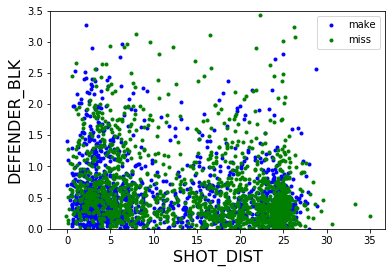

In [17]:
xnames1 = ['SHOT_DIST', 'DEFENDER_BLK']
X1 = Xtrain[xnames1].values

plot_cnt(X1,y,xnames1,ylim=(0,3.5),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

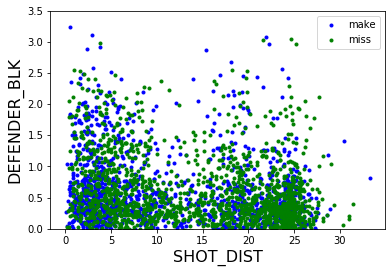

In [18]:
plot_cnt(X1,y,xnames1,ylim=(0,3.5),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

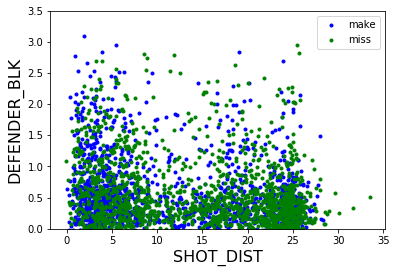

In [19]:
plot_cnt(X1,y,xnames1,ylim=(0,3.5),start=6000,end=9000)

There seems to be a dense region of made shots around higher shot distance and lower BPG of the closest defender and more missed shots closer to the rim. Just to note, defensive stats such as BPG are not always great indicators of a player's defensive ability. 

In [20]:
xnames2 = ['SHOT_DIST', 'CLOSE_DEF_DIST']
X2 = Xtrain[xnames2].values

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

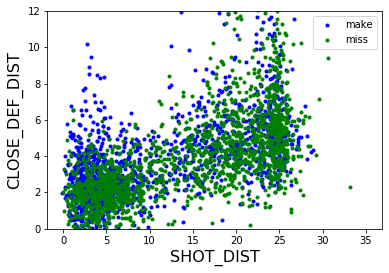

In [21]:
plot_cnt(X2,y,xnames2,ylim=(0,12),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

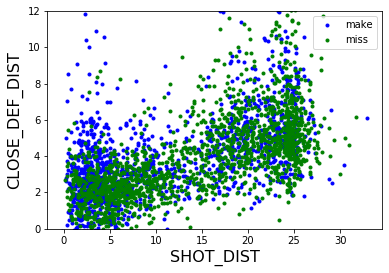

In [22]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

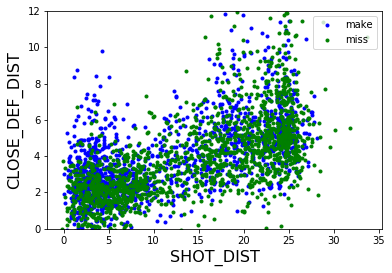

In [23]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=6000,end=9000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

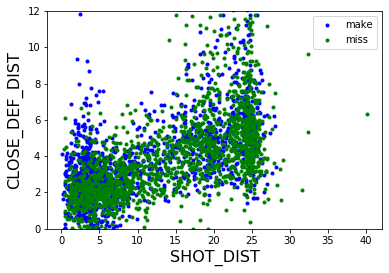

In [24]:
plot_cnt(X2,y,xnames2,ylim=(0,12),start=9000,end=12000)

Similar to the relationship between shot distance and distance of the closest defender, there seems to be less missed shots the further away we get from the rim, even if the closest defender is pretty close. It seems that shots at the rim are easier to contest than jump shots, given the nature of how each shot is attempted.

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

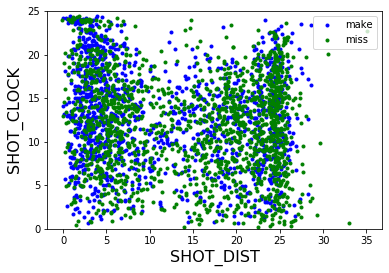

In [25]:
xnames3 = ['SHOT_DIST', 'SHOT_CLOCK']
X3 = Xtrain[xnames3].values

plot_cnt(X3,y,xnames3,ylim=(0,25),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

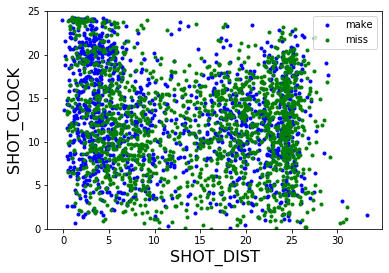

In [26]:
plot_cnt(X3,y,xnames3,ylim=(0,25),start=3000,end=6000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

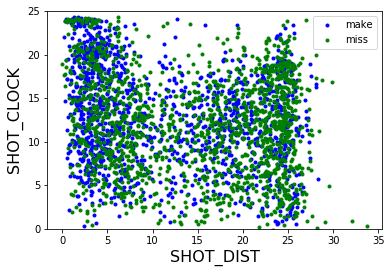

In [27]:
plot_cnt(X3,y,xnames3,ylim=(0,25),start=6000,end=9000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

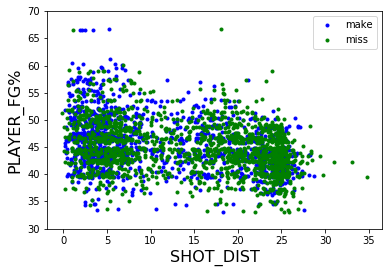

In [28]:
xnames4 = ['SHOT_DIST', 'PLAYER_FG%']
X4 = Xtrain[xnames4].values

plot_cnt(X4,y,labels=xnames4,ylim=(30,70),end=3000)

<module 'matplotlib.pyplot' from '/home/irvin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

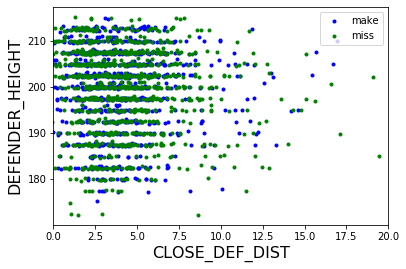

In [29]:
xnames5 = ['CLOSE_DEF_DIST', 'DEFENDER_HEIGHT']
X5 = Xtrain[xnames5].values

plot_cnt(X5,y,xnames5,xlim=(0,20),end=2000)

In [30]:
# feature transformations
Xtrain_new['SHOT_DST/DEF_BLKS'] = \
    Xtrain_new['SHOT_DIST']/Xtrain_new['DEFENDER_BLK']

Xtest_new['SHOT_DST/DEF_BLKS'] = \
    Xtest_new['SHOT_DIST']/Xtest_new['DEFENDER_BLK']

In [31]:
Xtrain_new[Xtrain_new['SHOT_DST/DEF_BLKS'] == np.inf]

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H,SHOT_DST/DEF_BLKS
52950,11,4,247.0,15.5,1,17.7,2,3.0,187.5,187.5,18.9,44.5,28.5,75.2,1.2,0.0,0,1,inf
98085,1,4,33.0,16.3,3,18.9,2,4.7,195.0,190.0,3.9,40.0,37.5,72.9,0.3,0.0,0,1,inf
2666,2,2,554.0,9.3,2,12.3,2,2.8,202.5,190.0,10.4,43.4,35.8,62.8,0.5,0.0,1,0,inf
22770,3,1,552.0,15.3,3,18.9,2,3.7,195.0,187.5,14.6,39.6,23.5,69.4,0.7,0.0,0,1,inf
52905,2,1,89.0,7.7,3,7.1,2,4.5,182.5,187.5,10.0,42.7,35.1,82.7,1.2,0.0,0,1,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27183,7,1,94.0,20.1,1,6.7,2,18.8,205.0,190.0,21.9,50.2,40.0,72.8,0.4,0.0,0,1,inf
7804,4,2,380.0,15.2,0,25.0,3,4.3,182.5,180.0,12.8,36.8,31.8,75.2,0.6,0.0,1,0,inf
8046,5,4,555.0,15.2,10,21.2,2,2.8,187.5,180.0,7.4,43.8,30.6,67.9,0.6,0.0,0,1,inf
7609,13,4,609.0,18.0,5,24.3,3,8.3,182.5,180.0,10.0,42.7,35.1,82.7,0.4,0.0,0,1,inf


In [32]:
Xtrain_new = Xtrain_new.replace([np.inf, -np.inf],0)
Xtest_new = Xtest_new.replace([np.inf, -np.inf],0)

In [33]:
Xtrain_new

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PLAYER_HEIGHT,DEFENDER_HEIGHT,PLAYER_PTS,PLAYER_FG%,PLAYER_3P%,PLAYER_FT%,DEFENDER_STL,DEFENDER_BLK,LOCATION_A,LOCATION_H,SHOT_DST/DEF_BLKS
93851,9,2,2.0,0.3,27,22.2,2,1.5,195.0,187.5,16.6,44.7,30.4,69.4,0.7,0.3,0,1,74.000000
5515,12,3,168.0,6.3,6,18.5,2,0.5,187.5,190.0,21.7,46.8,41.5,86.3,0.7,0.2,0,1,92.500000
70528,8,4,494.0,17.9,0,1.1,2,2.0,202.5,210.0,10.3,50.2,0.0,71.7,0.5,0.4,1,0,2.750000
79878,1,1,646.0,11.8,1,14.3,2,3.7,212.5,207.5,17.4,49.4,17.6,79.5,0.6,0.9,1,0,15.888889
52950,11,4,247.0,15.5,1,17.7,2,3.0,187.5,187.5,18.9,44.5,28.5,75.2,1.2,0.0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63228,5,2,341.0,12.6,1,15.8,2,5.6,193.0,192.5,21.5,47.0,28.4,76.8,1.9,0.7,1,0,22.571429
9874,3,1,241.0,16.7,7,17.3,2,3.3,192.5,197.5,12.1,43.7,33.1,84.8,0.8,0.2,0,1,86.500000
101158,12,3,264.0,6.1,1,19.9,2,6.4,205.0,202.5,16.4,43.4,36.7,80.4,0.6,0.8,0,1,24.875000
48872,26,4,529.0,22.0,0,27.9,3,4.4,182.5,192.5,14.2,39.7,34.2,87.2,0.8,0.1,1,0,279.000000


In [34]:
scaler_new = StandardScaler()
scaler_new.fit(Xtrain_new)
Xtrain_norm_new = scaler_new.transform(Xtrain_new)
scaler_new.fit(Xtest_new)
Xtest_norm_new = scaler_new.transform(Xtest_new)

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=100)
neigh1.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [36]:
yhat_ts_norm = neigh1.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy: {0:f}'.format(acc))

Accuracy: 0.601351


Very small increase in accuracy. Let's manually add weights. These weights are a guess on how much a certain feature will play into determining whether a shot is a miss or make. This is just from years of watching and playing basketball. 

In [37]:
# increase weight of player PPG by 5 
Xtrain_norm_new[:,10] = Xtrain_norm_new[:,10] * 5

# increase weight of player FG% by 5
Xtrain_norm_new[:,11] = Xtrain_norm_new[:,11] * 5

# increase weight of player 3P% by 2
Xtrain_norm_new[:,12] = Xtrain_norm_new[:,12] * 2

# increase weight of closest defender distance by 3
Xtrain_norm_new[:,7] = Xtrain_norm_new[:,7] * 3

# increase weight of shot distance by 2
Xtrain_norm_new[:,5] = Xtrain_norm_new[:,5] * 2

In [38]:
# do the same for Xtest
Xtest_norm_new[:,10] = Xtest_norm_new[:,10] * 5
Xtest_norm_new[:,11] = Xtest_norm_new[:,11] * 5
Xtest_norm_new[:,12] = Xtest_norm_new[:,12] * 2
Xtest_norm_new[:,7] = Xtest_norm_new[:,7] * 3
Xtest_norm_new[:,5] = Xtest_norm_new[:,5] * 2

In [39]:
Xtrain_norm_new[0]

array([ 0.54016505, -0.41531748, -1.77558778, -2.12320749,  7.24355646,
        1.96530223, -0.59687287, -2.88713661, -0.2675319 , -1.29391504,
        3.28236443, -0.51617126,  0.02396566, -0.80836072, -0.27819995,
       -0.49304919, -1.00022409,  1.00022409,  0.4384476 ])

In [40]:
neigh1 = KNeighborsClassifier(n_neighbors=100)
neigh1.fit(Xtrain_norm_new,ytrain)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [41]:
yhat_ts_norm = neigh1.predict(Xtest_norm_new)
acc = np.mean(ytest.values == yhat_ts_norm)
print('Accuracy: {0:f}'.format(acc))

Accuracy: 0.602763


Accuracy went down a bit. It seems that manually setting these weights is difficult, let's try using a neural network to learn these weights/biases/features automatically 

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation 
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

In [54]:
ytrain = ytrain.values
ytest = ytest.values

In [43]:
# renormalize test and train sets
Xtr_new = Xtrain.drop(['FGM','PTS'], axis=1)
Xts_new = Xtest.drop(['FGM', 'PTS'], axis=1)
scaler_new = StandardScaler()
scaler_new.fit(Xtr_new)
Xtr_norm = scaler_new.transform(Xtr_new)
scaler_new.fit(Xts_new)
Xts_norm = scaler_new.transform(Xts_new)

In [44]:
K.clear_session()

In [45]:
Xtr_new.shape

(89258, 18)

In [46]:
nin = Xtr_new.shape[1] # number of inputs 
nout = 1 # make or miss

In [47]:
# model with two hidden layers with 4 hidden units each
# using sigmoid activation 
model1S = Sequential()
model1S.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model1S.add(Dense(units=4, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model1S.add(Dense(units=nout, activation='sigmoid', name='output'))

In [48]:
model1S.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 4)                 76        
_________________________________________________________________
hidden2 (Dense)              (None, 4)                 20        
_________________________________________________________________
output (Dense)               (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [49]:
opt = optimizers.Adam(lr=0.001)
model1S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [55]:
model1S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 6s 67us/sample - loss: 0.6914 - accuracy: 0.5534 - val_loss: 0.6724 - val_accuracy: 0.6039
Epoch 2/30
89258/89258 [==============================] - 5s 60us/sample - loss: 0.6674 - accuracy: 0.6074 - val_loss: 0.6634 - val_accuracy: 0.6054
Epoch 3/30
89258/89258 [==============================] - 6s 67us/sample - loss: 0.6616 - accuracy: 0.6092 - val_loss: 0.6599 - val_accuracy: 0.6114
Epoch 4/30
89258/89258 [==============================] - 6s 68us/sample - loss: 0.6592 - accuracy: 0.6123 - val_loss: 0.6577 - val_accuracy: 0.6108
Epoch 5/30
89258/89258 [==============================] - 5s 61us/sample - loss: 0.6577 - accuracy: 0.6135 - val_loss: 0.6563 - val_accuracy: 0.6151
Epoch 6/30
89258/89258 [==============================] - 5s 61us/sample - loss: 0.6567 - accuracy: 0.6127 - val_loss: 0.6552 - val_accuracy: 0.6146
Epoch 7/30
89258/89258 [==============================] 

In [56]:
# model with two hidden layers with 8 hidden units each
# using sigmoid activation 
model2S = Sequential()
model2S.add(Dense(units=8, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model2S.add(Dense(units=8, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model2S.add(Dense(units=nout, activation='sigmoid', name='output'))
model2S.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 8)                 152       
_________________________________________________________________
hidden2 (Dense)              (None, 8)                 72        
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 233
Trainable params: 233
Non-trainable params: 0
_________________________________________________________________


In [57]:
model2S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [58]:
model2S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 81us/sample - loss: 0.6679 - accuracy: 0.5991 - val_loss: 0.6606 - val_accuracy: 0.6089
Epoch 2/30
89258/89258 [==============================] - 6s 68us/sample - loss: 0.6594 - accuracy: 0.6099 - val_loss: 0.6577 - val_accuracy: 0.6141
Epoch 3/30
89258/89258 [==============================] - 6s 73us/sample - loss: 0.6574 - accuracy: 0.6122 - val_loss: 0.6558 - val_accuracy: 0.6116
Epoch 4/30
89258/89258 [==============================] - 6s 71us/sample - loss: 0.6561 - accuracy: 0.6137 - val_loss: 0.6545 - val_accuracy: 0.6144
Epoch 5/30
89258/89258 [==============================] - 6s 67us/sample - loss: 0.6550 - accuracy: 0.6150 - val_loss: 0.6536 - val_accuracy: 0.6149
Epoch 6/30
89258/89258 [==============================] - 7s 73us/sample - loss: 0.6541 - accuracy: 0.6165 - val_loss: 0.6530 - val_accuracy: 0.6153
Epoch 7/30
89258/89258 [==============================] 

In [59]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model3S = Sequential()
model3S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model3S.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model3S.add(Dense(units=nout, activation='sigmoid', name='output'))
model3S.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 12)                228       
_________________________________________________________________
hidden2 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 1)                 13        
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


In [60]:
model3S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [61]:
model3S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 8s 94us/sample - loss: 0.6661 - accuracy: 0.6002 - val_loss: 0.6595 - val_accuracy: 0.6077
Epoch 2/30
89258/89258 [==============================] - 8s 86us/sample - loss: 0.6596 - accuracy: 0.6097 - val_loss: 0.6576 - val_accuracy: 0.6089
Epoch 3/30
89258/89258 [==============================] - 8s 92us/sample - loss: 0.6581 - accuracy: 0.6112 - val_loss: 0.6565 - val_accuracy: 0.6087
Epoch 4/30
89258/89258 [==============================] - 8s 84us/sample - loss: 0.6570 - accuracy: 0.6124 - val_loss: 0.6555 - val_accuracy: 0.6128
Epoch 5/30
89258/89258 [==============================] - 6s 69us/sample - loss: 0.6560 - accuracy: 0.6138 - val_loss: 0.6543 - val_accuracy: 0.6128
Epoch 6/30
89258/89258 [==============================] - 6s 72us/sample - loss: 0.6552 - accuracy: 0.6143 - val_loss: 0.6535 - val_accuracy: 0.6154
Epoch 7/30
89258/89258 [==============================] 

In [62]:
# model with two hidden layers with 16 hidden units each
# using sigmoid activation 
model4S = Sequential()
model4S.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model4S.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model4S.add(Dense(units=nout, activation='sigmoid', name='output'))
model4S.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                304       
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 593
Trainable params: 593
Non-trainable params: 0
_________________________________________________________________


In [63]:
model4S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [64]:
model4S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 81us/sample - loss: 0.6644 - accuracy: 0.6018 - val_loss: 0.6587 - val_accuracy: 0.6088
Epoch 2/30
89258/89258 [==============================] - 6s 72us/sample - loss: 0.6588 - accuracy: 0.6101 - val_loss: 0.6576 - val_accuracy: 0.6055
Epoch 3/30
89258/89258 [==============================] - 7s 75us/sample - loss: 0.6574 - accuracy: 0.6107 - val_loss: 0.6557 - val_accuracy: 0.6132
Epoch 4/30
89258/89258 [==============================] - 6s 72us/sample - loss: 0.6562 - accuracy: 0.6123 - val_loss: 0.6545 - val_accuracy: 0.6130
Epoch 5/30
89258/89258 [==============================] - 6s 73us/sample - loss: 0.6553 - accuracy: 0.6134 - val_loss: 0.6540 - val_accuracy: 0.6125
Epoch 6/30
89258/89258 [==============================] - 6s 69us/sample - loss: 0.6545 - accuracy: 0.6147 - val_loss: 0.6528 - val_accuracy: 0.6153
Epoch 7/30
89258/89258 [==============================] 

In [65]:
# model with two hidden layers with 20 hidden units each
# using sigmoid activation 
model5S = Sequential()
model5S.add(Dense(units=20, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model5S.add(Dense(units=20, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model5S.add(Dense(units=nout, activation='sigmoid', name='output'))
model5S.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 20)                380       
_________________________________________________________________
hidden2 (Dense)              (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 1)                 21        
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________


In [66]:
model5S.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [67]:
model5S.fit(Xtr_norm, ytrain, epochs=30, batch_size=100, validation_data=(Xts_norm,ytest))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 8s 87us/sample - loss: 0.6645 - accuracy: 0.6017 - val_loss: 0.6582 - val_accuracy: 0.6078
Epoch 2/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6582 - accuracy: 0.6107 - val_loss: 0.6559 - val_accuracy: 0.6098
Epoch 3/30
89258/89258 [==============================] - 7s 74us/sample - loss: 0.6565 - accuracy: 0.6118 - val_loss: 0.6557 - val_accuracy: 0.6068
Epoch 4/30
89258/89258 [==============================] - 7s 83us/sample - loss: 0.6551 - accuracy: 0.6127 - val_loss: 0.6537 - val_accuracy: 0.6104
Epoch 5/30
89258/89258 [==============================] - 7s 78us/sample - loss: 0.6540 - accuracy: 0.6153 - val_loss: 0.6523 - val_accuracy: 0.6154
Epoch 6/30
89258/89258 [==============================] - 7s 74us/sample - loss: 0.6531 - accuracy: 0.6161 - val_loss: 0.6524 - val_accuracy: 0.6132
Epoch 7/30
89258/89258 [==============================] 

Accuracy doesn't seem to go over 62% with any of the models trained.
We did not include the identity of either the player or the closest defender. Would that play a role in increasing accuracy?


In [70]:
data1 = pd.read_csv('Data/data.csv')

# separate data into matrix of predictor variables and vector of target variables
names1 = ['LOCATION', 'PLAYER_NAME', 'CLOSEST_DEFENDER','SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK',
         'DRIBBLES', 'SHOT_DIST', 'PTS_TYPE', 'CLOSE_DEF_DIST', 
         'PLAYER_HEIGHT','DEFENDER_HEIGHT', 'PLAYER_PTS', 'PLAYER_FG%', 'PLAYER_3P%',
          'PLAYER_FT%','DEFENDER_STL', 'DEFENDER_BLK', 'SHOT_RESULT']

# convert shot_result to either 0 or 1
data1['SHOT_RESULT'] = (data1['SHOT_RESULT'] == 'made').astype(int)

# convert game_clock to seconds
data1['GAME_CLOCK'] = data1['GAME_CLOCK'].apply(lambda x: convert_time(x))

# encode categorical data 
data_encoded = pd.get_dummies(data1[names1])

# split into train and test set with roughly 75-25 split
train, test = train_test_split(data_encoded, test_size=0.25)
Xtr1 = train.drop(['SHOT_RESULT'], axis=1)
ytr1 = train['SHOT_RESULT']
Xts1 = test.drop(['SHOT_RESULT'], axis=1)
yts1 = test['SHOT_RESULT']

In [71]:
ytr1 = ytr1.values
yts1 = yts1.values

In [86]:
# normalization
scaler = StandardScaler()
scaler.fit(Xtr1)
Xtr1 = scaler.transform(Xtr1)
scaler.fit(Xts1)
Xts1 = scaler.transform(Xts1)

In [87]:
K.clear_session()

In [88]:
Xtr1.shape

(89258, 769)

In [89]:
nin = Xtr1.shape[1] # number of inputs 
nout = 1 # make or miss

In [90]:
# model with two hidden layers with 100 hidden units each
# using sigmoid activation 
model100 = Sequential()
model100.add(Dense(units=100, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model100.add(Dense(units=100, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model100.add(Dense(units=nout, activation='sigmoid', name='output'))
model100.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               77000     
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
output (Dense)               (None, 1)                 101       
Total params: 87,201
Trainable params: 87,201
Non-trainable params: 0
_________________________________________________________________


In [91]:
model100.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [92]:
model100.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 11s 128us/sample - loss: 0.6763 - accuracy: 0.5783 - val_loss: 0.6663 - val_accuracy: 0.5968
Epoch 2/30
89258/89258 [==============================] - 10s 111us/sample - loss: 0.6591 - accuracy: 0.6081 - val_loss: 0.6614 - val_accuracy: 0.6040
Epoch 3/30
89258/89258 [==============================] - 10s 112us/sample - loss: 0.6509 - accuracy: 0.6173 - val_loss: 0.6599 - val_accuracy: 0.6113
Epoch 4/30
89258/89258 [==============================] - 10s 110us/sample - loss: 0.6426 - accuracy: 0.6251 - val_loss: 0.6594 - val_accuracy: 0.6139
Epoch 5/30
89258/89258 [==============================] - 10s 109us/sample - loss: 0.6339 - accuracy: 0.6346 - val_loss: 0.6635 - val_accuracy: 0.6108
Epoch 6/30
89258/89258 [==============================] - 10s 114us/sample - loss: 0.6222 - accuracy: 0.6437 - val_loss: 0.6681 - val_accuracy: 0.6017
Epoch 7/30
89258/89258 [====================

Validation accuracy horrible while training accuracy goes up. Overfitting? Decrease hidden units. Let's start low again. From 16 let's say. And go up to ~50

In [93]:
# model with two hidden layers with 16 hidden units each
# using sigmoid activation 
model16 = Sequential()
model16.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model16.add(Dense(units=16, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model16.add(Dense(units=nout, activation='sigmoid', name='output'))
model16.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 16)                12320     
_________________________________________________________________
hidden2 (Dense)              (None, 16)                272       
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 12,609
Trainable params: 12,609
Non-trainable params: 0
_________________________________________________________________


In [94]:
model16.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [96]:
model16.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 84us/sample - loss: 0.6766 - accuracy: 0.5793 - val_loss: 0.6666 - val_accuracy: 0.5992
Epoch 2/30
89258/89258 [==============================] - 7s 78us/sample - loss: 0.6603 - accuracy: 0.6082 - val_loss: 0.6634 - val_accuracy: 0.6040
Epoch 3/30
89258/89258 [==============================] - 8s 88us/sample - loss: 0.6540 - accuracy: 0.6163 - val_loss: 0.6611 - val_accuracy: 0.6086
Epoch 4/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6491 - accuracy: 0.6214 - val_loss: 0.6601 - val_accuracy: 0.6099
Epoch 5/30
89258/89258 [==============================] - 9s 98us/sample - loss: 0.6445 - accuracy: 0.6269 - val_loss: 0.6604 - val_accuracy: 0.6097
Epoch 6/30
89258/89258 [==============================] - 9s 103us/sample - loss: 0.6402 - accuracy: 0.6316 - val_loss: 0.6610 - val_accuracy: 0.6082
Epoch 7/30
89258/89258 [==============================]

In [99]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model12 = Sequential()
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model12.add(Dense(units=nout, activation='sigmoid', name='output'))
model12.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 12)                9240      
_________________________________________________________________
hidden2 (Dense)              (None, 12)                156       
_________________________________________________________________
output (Dense)               (None, 1)                 13        
Total params: 9,409
Trainable params: 9,409
Non-trainable params: 0
_________________________________________________________________


In [101]:
model12.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [103]:
model20.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 8s 88us/sample - loss: 0.6748 - accuracy: 0.5809 - val_loss: 0.6672 - val_accuracy: 0.5983
Epoch 2/30
89258/89258 [==============================] - 8s 89us/sample - loss: 0.6612 - accuracy: 0.6062 - val_loss: 0.6639 - val_accuracy: 0.6027
Epoch 3/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6549 - accuracy: 0.6149 - val_loss: 0.6619 - val_accuracy: 0.6052
Epoch 4/30
89258/89258 [==============================] - 9s 100us/sample - loss: 0.6500 - accuracy: 0.6201 - val_loss: 0.6596 - val_accuracy: 0.6100
Epoch 5/30
89258/89258 [==============================] - 9s 99us/sample - loss: 0.6451 - accuracy: 0.6259 - val_loss: 0.6589 - val_accuracy: 0.6101
Epoch 6/30
89258/89258 [==============================] - 9s 100us/sample - loss: 0.6404 - accuracy: 0.6307 - val_loss: 0.6600 - val_accuracy: 0.6103
Epoch 7/30
89258/89258 [==============================

In [ ]:
# model with two hidden layers with 12 hidden units each
# using sigmoid activation 
model12 = Sequential()
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden1'))
model12.add(Dense(units=12, input_shape=(nin,), activation='sigmoid', name='hidden2'))
model12.add(Dense(units=nout, activation='sigmoid', name='output'))
model12.summary()

In [104]:
model12.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [105]:
model12.fit(Xtr1, ytr1, epochs=30, batch_size=100, validation_data=(Xts1,yts1))

Train on 89258 samples, validate on 29753 samples
Epoch 1/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6764 - accuracy: 0.5782 - val_loss: 0.6675 - val_accuracy: 0.5987
Epoch 2/30
89258/89258 [==============================] - 7s 77us/sample - loss: 0.6616 - accuracy: 0.6066 - val_loss: 0.6647 - val_accuracy: 0.6036
Epoch 3/30
89258/89258 [==============================] - 7s 82us/sample - loss: 0.6557 - accuracy: 0.6143 - val_loss: 0.6629 - val_accuracy: 0.6057
Epoch 4/30
89258/89258 [==============================] - 8s 85us/sample - loss: 0.6513 - accuracy: 0.6189 - val_loss: 0.6616 - val_accuracy: 0.6077
Epoch 5/30
89258/89258 [==============================] - 9s 100us/sample - loss: 0.6472 - accuracy: 0.6241 - val_loss: 0.6616 - val_accuracy: 0.6067
Epoch 6/30
89258/89258 [==============================] - 8s 94us/sample - loss: 0.6433 - accuracy: 0.6283 - val_loss: 0.6611 - val_accuracy: 0.6060
Epoch 7/30
89258/89258 [==============================]

reweight parameters 
try different number of neighbors
feature transformation 
- ratio of shot distance to shot defender, etc
- do we keep the original features 
try logistic regression 
 

In [ ]:
Xtrain_new['SHOT_DIST']/Xtrain_new['DEFENDER_BLK']

In [ ]:
plt.ylim(6)